In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os

import time
from numba import jit, types
from numba.extending import overload, register_jitable
from numba.core.errors import TypingError

In [2]:
parametry = []

with open("parameters.txt") as f:
        for line in f.readlines():
            for value in line.split():
                try:
                    parametry.append(float(value))
                except:
                    pass

n, m, e, R, f, L, a, T_0, tau, S_o, S_d, S_out, S_xyz = parametry

n = int(n)
S_o = int(S_o)
S_d = int(S_d)
S_out = int(S_out)
S_xyz = int(S_xyz)
N = pow(n,3)

#L = 1.22*a*(n-1)
kB = 8.31e-3

print(parametry)

[5.0, 1.0, 1.0, 0.38, 10000.0, 2.3, 0.38, 1000.0, 0.002, 100.0, 10000.0, 10.0, 10.0]


In [3]:
#krawędzie komórki elementarnej kryształu
b0 = np.array([a,0.,0.])
b1 = np.array([a/2., a*math.sqrt(3.)/2., 0.])
b2 = np.array([a/2., a*math.sqrt(3.)/6., a*math.sqrt(2./3.)])
    
r = np.zeros((N,3))
    
for i0 in range(n):
    for i1 in range(n):
        for i2 in range(n):
            i = i0 + i1*n + i2*pow(n,2)
            r[i,:] = (i0-(n-1.)/2.)*b0+(i1-(n-1.)/2.)*b1+(i2-(n-1.)/2.)*b2

#zapis położeń do pliku
plik = open("krysztal.xyz", "w")
plik.write(str(N)+"\n\n")
for i in range(N):
    plik.write("Ar"+" "+str(r[i,0])+" "+str(r[i,1])+" "+str(r[i,2])+"\n")
plik.write("\ntype Xyz")
plik.close()

# energie i pędy początkowe
E_kin = np.zeros((N,3))
p = np.zeros((N,3))
    
for i in range(N):
    for j in range(3):
        E_kin[i,j] = -0.5*kB*T_0*math.log(random.uniform(0.,1.))
        p[i,j] = np.random.choice([-1.,1.])*math.sqrt(2.*m*E_kin[i,j])
            
p = p - np.sum(p)/N 

In [4]:
V=0.
Vs=0.
Vp=0.

Fs = np.zeros((N,3))
Fp = np.zeros((N,3))
F = np.zeros((N,3))

P = 0.
    
for i in range(N):
    for j in range(i):
        r_ij = r[i,:]-r[j,:]
        r_ij_mod = np.linalg.norm(r_ij)
        Vp = Vp + e*(pow(R/r_ij_mod, 12) - 2.*pow(R/r_ij_mod,6))
        f_ij = 12*e*(pow(R/r_ij_mod,12) - pow(R/r_ij_mod,6))*r_ij/pow(r_ij_mod,2)
        Fp[i,:] = Fp[i,:] + f_ij
        Fp[j,:] = Fp[j,:] - f_ij
    
    r_i_mod = np.linalg.norm(r[i,:])
    if r_i_mod>=L:
        Vs = Vs + f*pow((r_i_mod-L),2)/2
        Fs[i,:] = Fs[i,:] + f*(L-r_i_mod)*r[i,:]/r_i_mod
    
    F[i,:] = Fs[i,:]+Fp[i,:]
    P = P + np.linalg.norm(F[i,:])/4./(math.pi)/pow(L,2)
V = Vs + Vp

In [5]:
print(V)

-669.2932036253563


In [6]:
def zapis_charakterystyk(plik, t, Ham, potenc, temper, cisn):
    plik.write(str(t)+"\t"+str(Ham)+"\t"+str(potenc)+"\t"+str(temper)+"\t"+str(cisn)+"\n")

    
def zapis_wspolrzednych(plik, poloz, Ekin):
    plik.write(str(N)+"\n")
    for i in range(N):
        plik.write("Ar"+" "+str(poloz[i,0])+" "+str(poloz[i,1])+" "+str(poloz[i,2])+"\n")
        # +" "+str(E_kin[i])    

In [7]:
czasTab=[]
hamiltTab=[]
tempTab=[]
cisnienieTab=[]

In [8]:


charakterystyki = "charakterystyki.txt"
wspolrzedne = "avs.dat"

plik_charakterystyki = open(charakterystyki, "w")
plik_wspolrzedne = open(wspolrzedne, "a")
plik_wspolrzedne.write(str(N)+"\n\n")


T_srednie = 0.
P_srednie = 0.
H_srednie = 0.
czas = 0


@jit(nopython = True)
def aktualizacja(r, V, Vs, Vp, Fs, F, P):
    V = 0
    Vs = 0
    Vp = 0  
    Fs = np.zeros((N,3))
    Fp = np.zeros((N,3))
    F = np.zeros((N,3))
    P = 0
    for i in range(N):
        for j in range(i):
            r_ij = r[i,:]-r[j,:]
            r_ij_mod = np.linalg.norm(r_ij)
            Vp = Vp + e*(pow(R/r_ij_mod, 12) - 2.*pow(R/r_ij_mod,6))
            f_ij = 12*e*(pow(R/r_ij_mod,12) - pow(R/r_ij_mod,6))*r_ij/pow(r_ij_mod,2)
            Fp[i,:] = Fp[i,:] + f_ij
            Fp[j,:] = Fp[j,:] - f_ij
        
        r_i_mod = np.linalg.norm(r[i,:])
        if r_i_mod>=L:
            Vs = Vs + f*pow((r_i_mod-L),2)/2
            Fs[i,:] = Fs[i,:] + f*(L-r_i_mod)*r[i,:]/r_i_mod

        F = np.add(Fs,Fp)
        P = P + np.linalg.norm(F[i,:])/4./(math.pi)/pow(L,2)
    V = Vs + Vp
    
    return V, Fs, F, P
    

for s in range(S_o+S_d):
    p = p + F*(tau/2)    #aktualizacja pędu
    r = r + p*(tau/m)    #aktualizacja polożeń
    
#     p = np.add(p, np.multiply(F, tau/2))
#     r = np.add(r, np.multiply(p, tau/m))
    
    #obliczanie nowego chwilowego potencjału, sił oraz ciśnienia
    V, Fs, F, P = aktualizacja(r, V, Vs, Vp, Fs, F, P)
    
#     p = np.add(p, np.multiply(F, tau/2))
    p = p + F*(tau/2)   #akualizacja pędu
    
    #obliczanie temp i H
    E_kin = np.zeros(N)   
    T = 0.
    H = 0.
    for i in range(N):
        p_mod = np.linalg.norm(p[i,:])
        E_kin[i] = pow(p_mod,2)/(2*m)
        T = T + 2/3/N/kB*(E_kin[i])
        H = H + E_kin[i]
    H = H + V
    czas = czas + tau
    
    if s % S_out == 0:
        zapis_charakterystyk(plik_charakterystyki, czas, H, V, T, P)
        print('%.2E' % H)
        czasTab.append(czas)
        hamiltTab.append(H)
        tempTab.append(T)
        cisnienieTab.append(P)
    if s % S_xyz == 0:
        zapis_wspolrzednych(plik_wspolrzedne, r, E_kin)

    if s >= S_o:
        T_srednie += T
        P_srednie += P
        H_srednie += H

        
T_srednie /= S_d
P_srednie /= S_d
H_srednie /= S_d
print(T_srednie)
print(P_srednie)
print(H_srednie)


plik_wspolrzedne.write("\ntype Xyz")
plik_charakterystyki.close()
plik_wspolrzedne.close()

elapsed_time = time.process_time()
print(elapsed_time)

9.27E+02
9.27E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.29E+02
9.28E+02
9.28E+02
9.29E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.29E+02
9.28E+02
9.28E+02
9.28E+02
9.27E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.27E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9

9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.28E+02
9.29E+02
9.28E+02
9.29E+02
9.29E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.29E+02
9.29E+02
9.29E+02
9.29E+02
9.28E+02
9.29E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
9.28E+02
618.2994353911979
33.69115028813034
928.7003385610353
103.03125


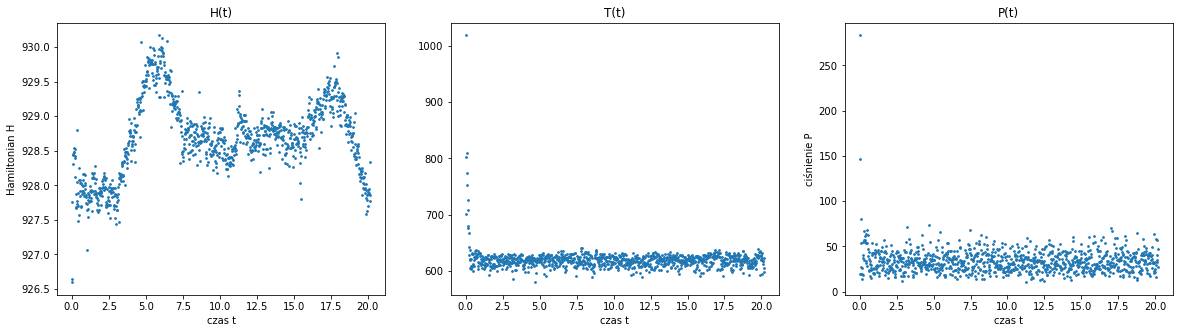

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

markersize=3

ax1.scatter(czasTab, hamiltTab, s=markersize)
ax1.set_title("H(t)")
ax1.set_xlabel("czas t")
ax1.set_ylabel("Hamiltonian H")
# ax1.set_ylim(-669.25, -669.35)

ax2.scatter(czasTab, tempTab, s=markersize)
ax2.set_title("T(t)")
ax2.set_xlabel("czas t")
#ax2.set_ylabel("temperatura T")

ax3.scatter(czasTab, cisnienieTab, s=markersize)
ax3.set_title("P(t)")
ax3.set_xlabel("czas t")
ax3.set_ylabel("ciśnienie P")

plt.show()